In [1]:
import os
import sys
from collections import namedtuple

import numpy as np
import matplotlib.pyplot as plt
from crccheck.crc import Crc16Modbus

sys.path.append("../extract_pin_addr")
from JicBitstream import JicBitstream, JicBitstreamZip

%matplotlib notebook

In [2]:
class JicCompressedBlockIterator:
    MAGIC_SIZE = 4
    HEADER_SIZE = 77660
    BLK_SIZE = 1188
    BLK_SIZE_ALT = 2332
    BLK_SIZE_ALT2 = 192
    BLK_SIZE_ALT3 = 12

    ALT_BLK_HEADER = np.array([0xC1, 0x68, 0x3, 0x0], dtype=np.uint8)
    ALT2_BLK_HEADER = np.array([0xEC, 0x64, 0x0, 0x0], dtype=np.uint8)
    ALT3_BLK_HEADER = np.array([0xAE, 0xFB, 0x0, 0x0], dtype=np.uint8)
    ALT4_BLK_HEADER = np.array([0xC1, 0x68, 0x31, 0x0], dtype=np.uint8)

    vhex = np.vectorize(hex)
    vchr = np.vectorize(chr)

    def __init__(self, jic: JicBitstream, sel, verbose=False):
        self.done = False
        self.verbose = verbose
        self._bs = jic.jic_uint8
        self.jjjj_locs = jic.find_jjjj_seqs()
        self._loc = self.jjjj_locs[sel]
        self.blk_idx = 0
        self.nibble_store = None
        self.decomp_enable = False

        magic = self.get(self.MAGIC_SIZE)
        if self.verbose:
            print("magic =", self.vchr(magic))

        self.bef_jjjj = self._bs[0 : self.jjjj_locs[0]]
        self.hdr = self.get(self.HEADER_SIZE)

    def _get_nibble(self) -> int:
        if self.nibble_store is not None:
            tmp = self.nibble_store
            self.nibble_store = None
            return tmp
        else:
            nxt_byte = self._get_direct(1)[0]
            ret = nxt_byte & 0xF
            self.nibble_store = (nxt_byte >> 4) & 0xF
            return ret

    def get(self, size: int) -> np.array:
        if self.decomp_enable:
            return self._get_decomp(size)
        else:
            return self._get_direct(size)

    def _get_direct(self, size: int) -> np.array:
        tmp = self._peek_direct(size)
        self._loc += size
        return tmp

    def _get_decomp(self, size: int) -> np.array:
        dec_bytes = []

        while len(dec_bytes) < size:
            dec_bytes.extend(self._get_decode_single())

        return np.array(dec_bytes, dtype=np.uint8)

    def _get_decode_single(self) -> list:
        decomp_nibbles = []
        pb = self._get_nibble()
        for i in range(4):
            if pb & (1 << i):
                decomp_nibbles.append(self._get_nibble())
            else:
                decomp_nibbles.append(0)

        assert len(decomp_nibbles) % 2 == 0

        decomp_bytes = []
        for lo, hi in zip(decomp_nibbles[::2], decomp_nibbles[1::2]):
            decomp_bytes.append(hi << 4 | lo)

        return decomp_bytes

    def peek(self, size: int) -> np.array:
        if self.decomp_enable:
            return self._peek_decomp(size)
        else:
            return self._peek_direct(size)

    def _peek_direct(self, size: int) -> np.array:
        return self._bs[self._loc : self._loc + size]

    def _peek_decomp(self, size: int) -> np.array:
        comp_bytes = self._peek_direct(size * (4 + 1) // 4 + 1)
        comp_nibbles = []
        for b in comp_bytes:
            comp_nibbles.append(b & 0xF)
            comp_nibbles.append((b >> 4) & 0xF)

        comp_nibbles = iter(comp_nibbles)
        decomp_nibbles = []
        while len(decomp_nibbles) < size * 2:
            pb = next(comp_nibbles)
            for i in range(4):
                if pb & (1 << i):
                    decomp_nibbles.append(next(comp_nibbles))
                else:
                    decomp_nibbles.append(0)

        assert len(decomp_nibbles) % 2 == 0

        decomp_bytes = []
        for lo, hi in zip(decomp_nibbles[::2], decomp_nibbles[1::2]):
            decomp_bytes.append(hi << 4 | lo)

        return np.array(decomp_bytes, dtype=np.uint8)

    def __iter__(self):
        return self

    def __next__(self):
        if self.done:
            raise StopIteration

        blk_header_direct = self._peek_direct(4)

        if blk_header_direct[0] == 0x4F:
            self.decomp_enable = True
            if self.verbose:
                print("enable decompression")

        blk_header = self.peek(4)
        loc = self._loc

        disable_chksum_check = False

        if np.all(blk_header == self.ALT_BLK_HEADER):
            blk = self.get(self.BLK_SIZE_ALT)
        elif np.all(blk_header == self.ALT2_BLK_HEADER):
            blk = self.get(self.BLK_SIZE_ALT2)
        elif np.all(blk_header_direct == self.ALT3_BLK_HEADER):
            blk = self.get(self.BLK_SIZE_ALT3)
            self.done = True
        elif np.all(blk_header_direct == self.ALT4_BLK_HEADER):
            hdr = self._get_direct(2)
            self.nibble_store = None
            payload = self._get_decomp(self.BLK_SIZE_ALT - 2)
            blk = np.concatenate((hdr, payload))
        else:
            blk = self.get(self.BLK_SIZE)

        chksum = Crc16Modbus.calc(blk)
        if self.verbose:
            print(
                "blk idx = ",
                self.blk_idx,
                "loc =",
                loc,
                ", blk header =",
                vhex(blk_header),
                "/",
                vhex(blk_header_direct),
                ", checksum = ",
                chksum,
                ", chksum field = ",
                vhex(blk[-2:]),
                ", len = ",
                len(blk),
            )

        if not disable_chksum_check:
            assert chksum == 0, "Checksum should be 0"
        else:
            raise StopIteration
            pass

        self.blk_idx += 1
        return blk

In [3]:
def decimate(orig, N):
    M = orig.shape[0] // N
    orig = orig[0 : N * M]
    orig = orig.reshape((M, N))
    dec = np.sum(orig, axis=1)
    return dec


def plot_bitstream(
    ax, bitstream, style="-", label="", N=1, lower_lim=None, upper_lim=None, bits=False
):
    """ Plot bitstream (pop count)

    Arguments
        N: decimation factor
    """

    jic = bitstream.reshape(-1)
    jic = np.unpackbits(jic)

    if lower_lim is not None:
        lower_lim *= 8

    if upper_lim is not None:
        upper_lim *= 8

    if lower_lim is not None and upper_lim is not None:
        jic = jic[lower_lim:upper_lim]
    elif lower_lim is not None:
        upper_lim = jic.shape[0]
        jic = jic[lower_lim:]
    elif upper_lim is not None:
        lower_lim = 0
        jic = jic[0:upper_lim]
    else:
        lower_lim = 0
        upper_lim = jic.shape[0]

    dec = decimate(jic, N * 8)
    x = np.linspace(lower_lim, upper_lim, len(dec))

    ax.plot(x, dec, style, label=label)

In [4]:
# factory.jic has two bitstreams (i.e. recovery image)

JIC_SEL = 1

blkiter_comp = JicCompressedBlockIterator(
    JicBitstream("../../bitstreams/ref/factory.jic"), JIC_SEL, verbose=False,
)

nr_bytes = 0
blks = []

for blk in blkiter_comp:
    blks.append(blk)
    nr_bytes += len(blk)

print(f"Total number of blocks = {len(blks)}")
print(f"Total size = {nr_bytes} bytes")

Total number of blocks = 21718
Total size = 26723164 bytes


In [5]:
bitstream_ref = []
bitstream_ref.extend(blkiter_comp.bef_jjjj[:-14])
bitstream_ref.extend(blkiter_comp.hdr)

for blk in blks:
    bitstream_ref.extend(blk)
    
bitstream_ref = np.array(bitstream_ref, dtype=np.uint8)
open("factory_decompress.jic", "wb").write(bitstream_ref)

26801118

<IPython.core.display.Javascript object>


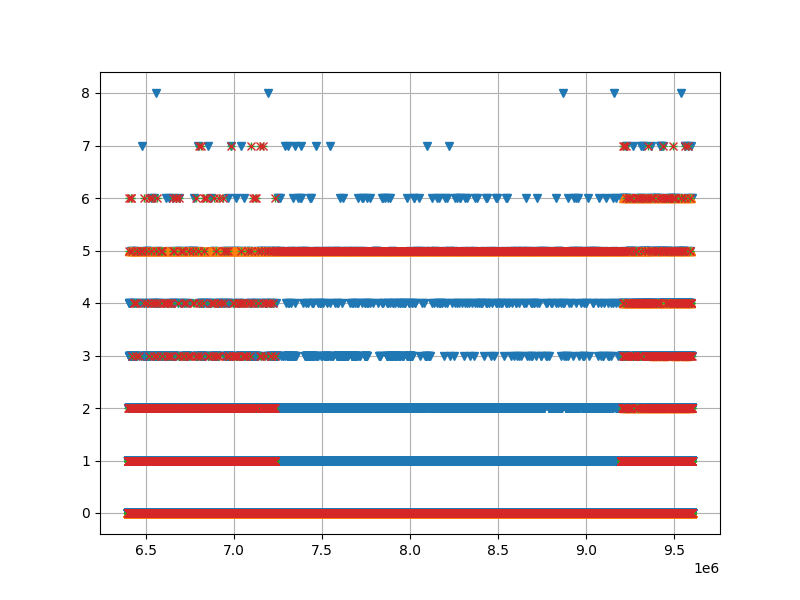

In [6]:
fig = plt.figure(figsize=(8, 6))
ax = fig.subplots()

N = 1

# lower_lim = None
# upper_lim = int(1e6)

# lower_lim = int(26e6)
# upper_lim = int(27e6)

lower_lim = 800000
upper_lim = 1200000

jic1 = JicBitstreamZip("../../results/out/T31_2V5_12mA_pu_off_dly_no.zip")
#jic2 = JicBitstream("../../bitstreams/ddr3_ex/default2.jic")
jic2 = JicBitstream("../../bitstreams/ddr3_ex/AH27_no_term.jic")
jic3 = JicBitstream("../../bitstreams/ddr3_ex/AJ29_no_term.jic")

plot_bitstream(
    ax, bitstream_ref, style="v", N=N, lower_lim=lower_lim, upper_lim=upper_lim
)
plot_bitstream(
    ax, jic1.jic_uint8, style="^", N=N, lower_lim=lower_lim, upper_lim=upper_lim
)
plot_bitstream(
    ax, jic2.jic_uint8, style="+", N=N, lower_lim=lower_lim, upper_lim=upper_lim
)
plot_bitstream(
    ax, jic3.jic_uint8, style="x", N=N, lower_lim=lower_lim, upper_lim=upper_lim
)

ax.grid(True)